# Imports

In [15]:
import numpy as np
import pandas as pd
import scipy as sp

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# O dataset

O dataset que vamos trabalhar é uma versão reduzida do Behavioral Risk Factor Surveillance System Survey de 2022, no qual algumas colunas foram selecionadas e tratadas de acordo com o notebook "./BRFSS_data_cleaning_2022.ipynb". No total, excluindo os dados nulos, estamos trabalhando com 205.738 amostras.

O dataset é público e está disponível em: https://www.cdc.gov/brfss/annual_data/annual_2022.html. A descrição de cada uma das colunas também está disponível no referido link.

Nosso target será a coluna ADDEPEV3, a qual se refere a seguinte pergunta do survey: "Have a doctor ever told you had a depressive disorder (including depression, major depression, dysthymia, or minor depression)?" Para a previsão do nosso target iremos utilizar 30 outras perguntas realizadas na pesquisa.

Vamos checar algumas informaçõs básicas do nosso dataset:


In [2]:
df_combined = pd.read_csv("../cleaned_data/brfss_filtered_2022_full.csv").drop(columns = 'Unnamed: 0')
df_combined.head(5)

,ADDEPEV3,_SEX,_AGE80,_RFHLTH,_HLTHPLN,MEDCOST1,CHECKUP1,_TOTINDA,SLEPTIM1,_MICHD,...,LSATISFY,EMTSUPRT,SDHISOLT,SDHEMPLY,SDHFOOD1,SDHBILLS,SDHUTILS,SDHTRNSP,SDHSTRE1,_RACEGR4
0,0.0,2.0,80.0,1.0,1.0,2.0,8.0,2.0,6.0,2.0,...,1.0,1.0,5.0,2.0,5.0,2.0,2.0,2.0,5.0,1.0
1,0.0,2.0,56.0,1.0,1.0,2.0,1.0,1.0,5.0,2.0,...,2.0,2.0,3.0,2.0,5.0,2.0,2.0,2.0,5.0,1.0
2,0.0,2.0,43.0,2.0,1.0,2.0,1.0,1.0,9.0,2.0,...,1.0,1.0,5.0,2.0,5.0,2.0,2.0,2.0,5.0,1.0
3,0.0,1.0,80.0,2.0,1.0,2.0,1.0,2.0,7.0,1.0,...,2.0,2.0,5.0,2.0,5.0,2.0,2.0,2.0,5.0,1.0
4,0.0,2.0,80.0,1.0,1.0,2.0,1.0,1.0,7.0,2.0,...,1.0,1.0,4.0,2.0,5.0,2.0,2.0,2.0,5.0,2.0


In [3]:
df_combined.columns

Index(['ADDEPEV3', '_SEX', '_AGE80', '_RFHLTH', '_HLTHPLN', 'MEDCOST1',
       'CHECKUP1', '_TOTINDA', 'SLEPTIM1', '_MICHD', '_LTASTH1', 'MARITAL',
       'EDUCA', 'RENTHOM1', 'EMPLOY1', 'CHILDREN', '_BMI5CAT', 'DECIDE',
       'DIFFALON', '_SMOKER3', 'ALCDAY4', 'LSATISFY', 'EMTSUPRT', 'SDHISOLT',
       'SDHEMPLY', 'SDHFOOD1', 'SDHBILLS', 'SDHUTILS', 'SDHTRNSP', 'SDHSTRE1',
       '_RACEGR4'],
      dtype='object')

In [4]:
df_combined.shape

(205738, 31)

In [5]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205738 entries, 0 to 205737
Data columns (total 31 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   ADDEPEV3  205738 non-null  float64
 1   _SEX      205738 non-null  float64
 2   _AGE80    205738 non-null  float64
 3   _RFHLTH   205738 non-null  float64
 4   _HLTHPLN  205738 non-null  float64
 5   MEDCOST1  205738 non-null  float64
 6   CHECKUP1  205738 non-null  float64
 7   _TOTINDA  205738 non-null  float64
 8   SLEPTIM1  205738 non-null  float64
 9   _MICHD    205738 non-null  float64
 10  _LTASTH1  205738 non-null  float64
 11  MARITAL   205738 non-null  float64
 12  EDUCA     205738 non-null  float64
 13  RENTHOM1  205738 non-null  float64
 14  EMPLOY1   205738 non-null  float64
 15  CHILDREN  205738 non-null  float64
 16  _BMI5CAT  205738 non-null  float64
 17  DECIDE    205738 non-null  float64
 18  DIFFALON  205738 non-null  float64
 19  _SMOKER3  205738 non-null  float64
 20  ALCD

O nosso target é desbalanceado, e precisaremos tratar isso no futuro.

In [6]:
df_combined["ADDEPEV3"].value_counts()

0.0    161265
1.0     44473
Name: ADDEPEV3, dtype: int64

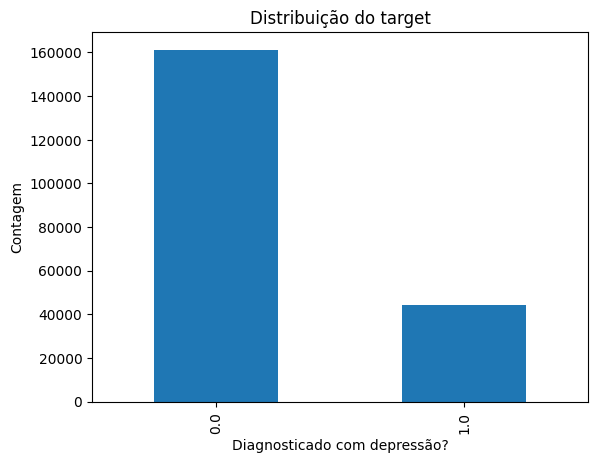

In [7]:
df_combined["ADDEPEV3"].value_counts().plot(kind='bar')
plt.title("Distribuição do target")
plt.ylabel("Contagem")
plt.xlabel("Diagnosticado com depressão?");

Também podemos checar uma matriz de correlação linear entre as features, onde notamos que inexiste correlação linear significativa entre as features, e entre as features e o nosso target.

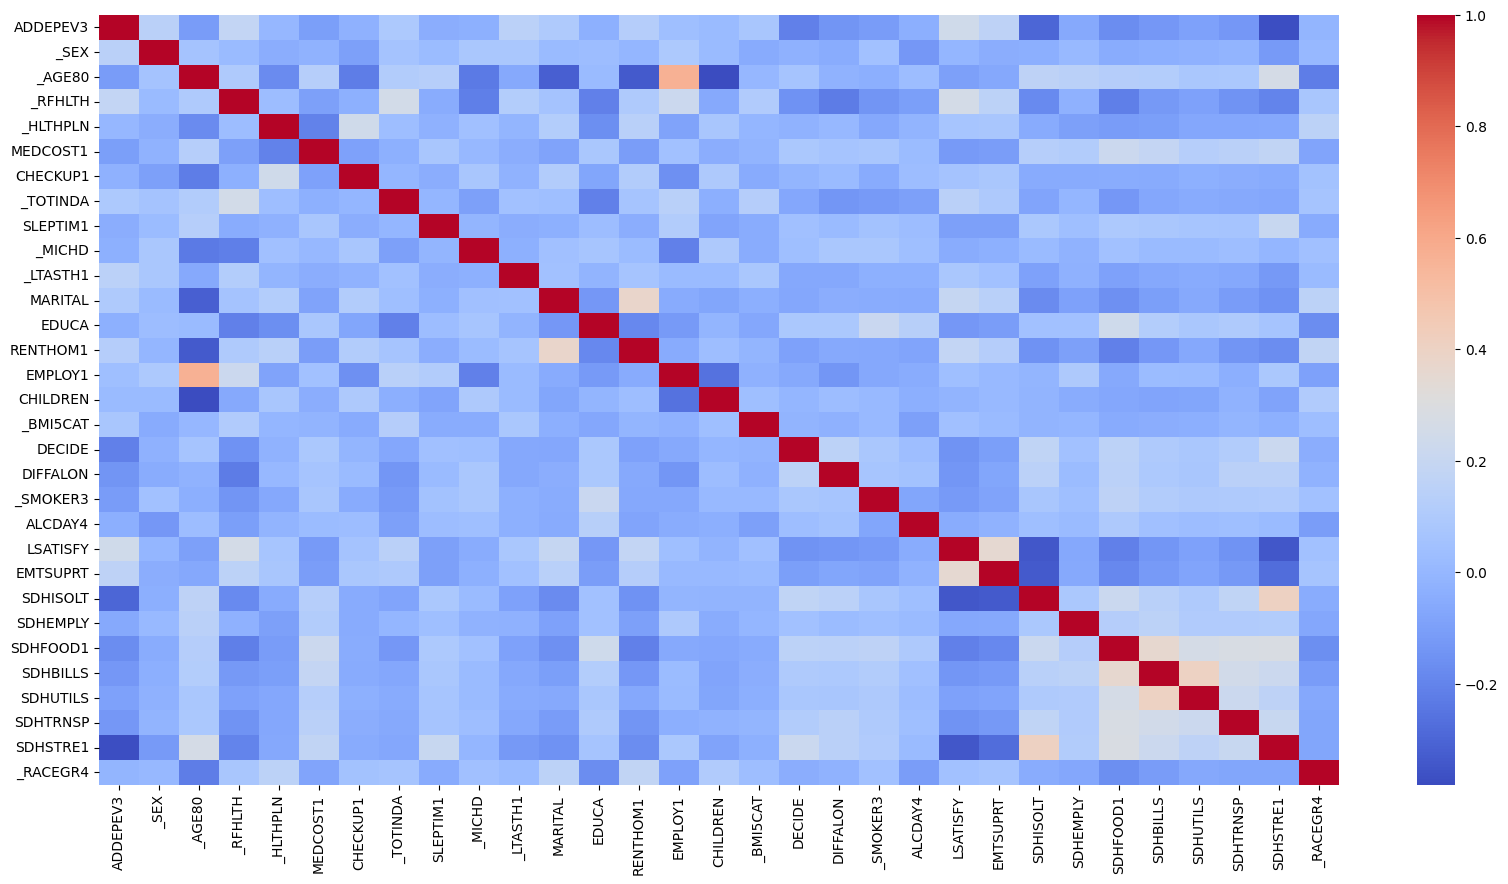

In [8]:
corr = df_combined.corr()
plt.figure(figsize=(20,10))
sns.heatmap(corr, cmap="coolwarm", annot=False);

Também podemos visualizar as relações entre os pares de features numéricas e o target. Como já notado no heatmap de correlação, não conseguimos extrair nenhua informação relevante entre essas combinações de features e o target.

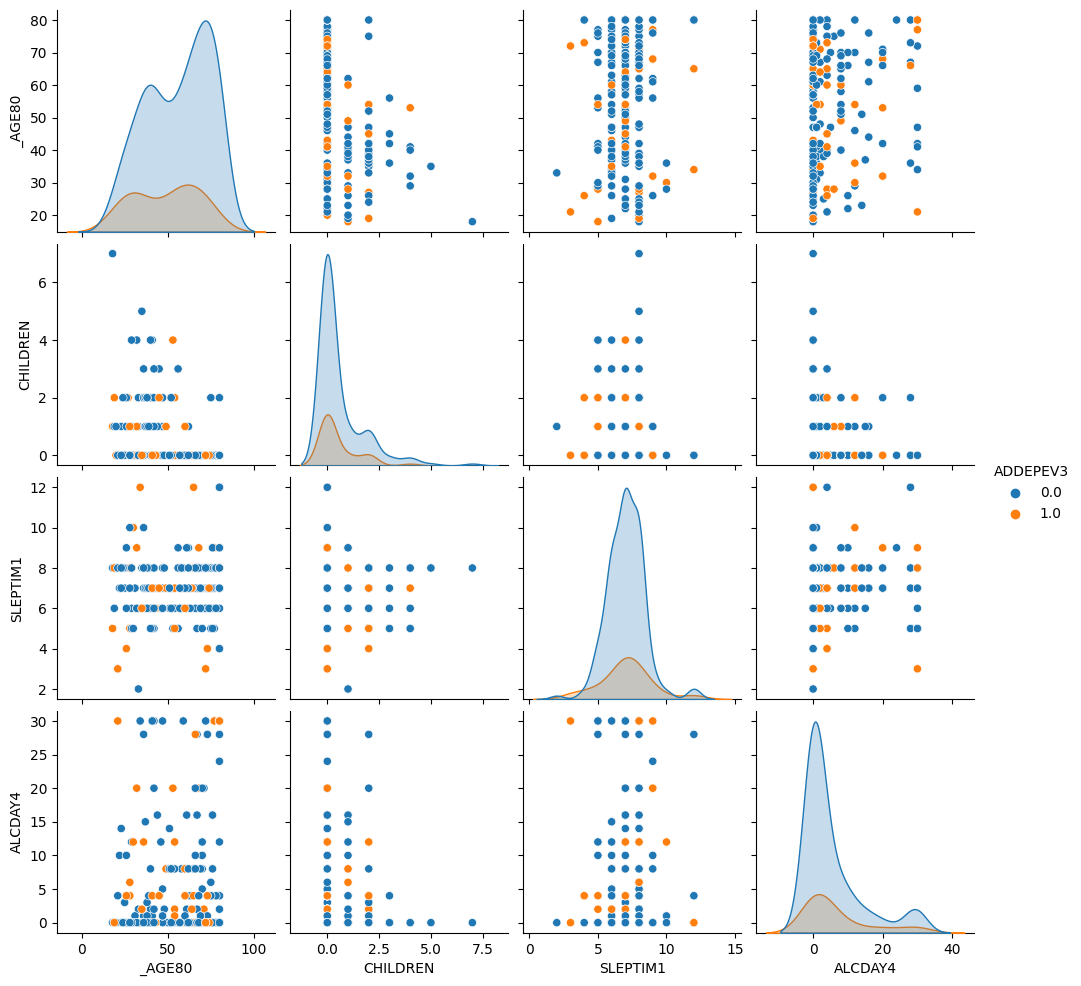

In [9]:
sns.pairplot(df_combined[["_AGE80", "CHILDREN", "SLEPTIM1", "ALCDAY4", "ADDEPEV3"]].sample(200),
             hue = "ADDEPEV3");

# Pré-processamento para machine learning

Primeiro, separar o X do y e fazer o train-test split, reservando 20% para teste.

In [10]:
y = df_combined["ADDEPEV3"]
X = df_combined.drop(columns = "ADDEPEV3")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Em seguida, separamos as features categóricas e as features numéricas. Nas features categóricas, realizamos One Hot Encoder, e nas features numéricas realizamos o seu escalonamento pelo Standard Scaler (subtraindo a média e dividindo pelo desvio padrão de cada feature).

In [11]:
cat_columns = ["_SEX", "_RFHLTH", "_HLTHPLN", "MEDCOST1", "CHECKUP1", "_TOTINDA", "_MICHD", "_LTASTH1",
               "MARITAL", "EDUCA", "RENTHOM1", "EMPLOY1", "_BMI5CAT", "DECIDE", "DIFFALON", "_SMOKER3",
               "LSATISFY", "EMTSUPRT", "SDHISOLT", "SDHEMPLY", "SDHFOOD1", "SDHBILLS", "SDHUTILS",
               "SDHTRNSP","SDHSTRE1", "_RACEGR4"]
num_columns = ["_AGE80", "CHILDREN", "SLEPTIM1", "ALCDAY4"]

preprocessor = ColumnTransformer([
    ('num_transformer', StandardScaler(), num_columns),
    ('cat_transformer', OneHotEncoder(handle_unknown="ignore"), cat_columns)],
    remainder='passthrough'
)

X_train_preproc = preprocessor.fit_transform(X_train)
X_test_preproc = preprocessor.transform(X_test)

In [19]:
X_test_df = pd.DataFrame(sp.sparse.csr_matrix.toarray(X_test_preproc))
X_test_df.to_csv("../cleaned_data/brfss_2022_X_test.csv")
y_test.to_csv("../cleaned_data/brfss_2022_y_test.csv")

Isso nos deixa, para treino, com 164.590 amostras, cada uma com 109 features.

In [141]:
X_train_preproc.shape

(164590, 109)

Como já notado anteriormente, nossos dados estão desbalanceados:

In [142]:
y_train.value_counts()

0.0    129005
1.0     35585
Name: ADDEPEV3, dtype: int64

In [143]:
X_train_preproc.shape

(164590, 109)

Vamos lidar com o desbalanceamento utilizando a técnica SMOTE (Synthetic Minority Oversampling Technique).

In [150]:
imb = SMOTE()

X_res, y_res = imb.fit_resample(X_train_preproc, y_train)

X_res_df = pd.DataFrame(sp.sparse.csr_matrix.toarray(X_res))
X_res_df.to_csv("../cleaned_data/brfss_2022_X_rebalanced.csv")
y_res.to_csv("../cleaned_data/brfss_2022_y_rebalanced.csv")

Agora, nosso target está balanceado.

In [16]:
y_res.value_counts()

0.0    128964
1.0    128964
Name: ADDEPEV3, dtype: int64

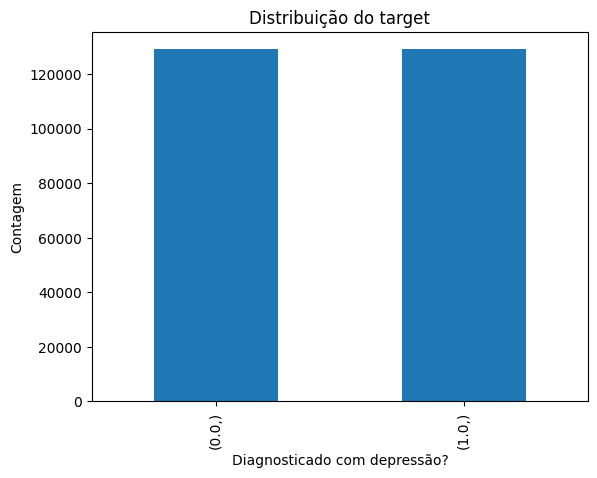

In [17]:
pd.DataFrame(y_res).value_counts().plot(kind='bar')
plt.title("Distribuição do target")
plt.ylabel("Contagem")
plt.xlabel("Diagnosticado com depressão?");

# Modelos e testes

In [18]:
models = {"Logistic Regression": LogisticRegression(max_iter = 10000), 
          "Tree": DecisionTreeClassifier(),
          "KNN": KNeighborsClassifier(n_neighbors=5),
          "SVM": SVC(kernel='rbf'),
          "Random Forest": RandomForestClassifier(n_estimators=100, criterion='entropy'),
          "XGBoost": XGBClassifier(use_label_encoder=False)}


results = {}
for key, value in models.items():
    print(f'Running cross validation for {key}')
    cv_results = cross_validate(value, X_res, y_res, cv = 5)
    mean_acc = cv_results['test_score'].mean()
    max_acc = cv_results['test_score'].max()
    print(f'{key} mean accuracy: {mean_acc}')
    print(f'{key} max accuracy: {max_acc}')
    results[key] = (mean_acc, max_acc)

Running cross validation for Logistic Regression
Logistic Regression mean accuracy: 0.7433469961774423
Logistic Regression max accuracy: 0.7472957779242431
Running cross validation for Tree
Tree mean accuracy: 0.8216949407162094
Tree max accuracy: 0.8883008626538722
Running cross validation for KNN
KNN mean accuracy: 0.8130021300015351
KNN max accuracy: 0.8240414065831815
Running cross validation for SVM
SVM mean accuracy: 0.826928932455776
SVM max accuracy: 0.8916157797809441
Running cross validation for Random Forest
Random Forest mean accuracy: 0.8795755093148255
Random Forest max accuracy: 0.9572364595045167
Running cross validation for XGBoost
XGBoost mean accuracy: 0.8662696450710063
XGBoost max accuracy: 0.9655132305902879


In [19]:
results

{'Logistic Regression': (0.7433469961774423, 0.7472957779242431),
 'Tree': (0.8216949407162094, 0.8883008626538722),
 'KNN': (0.8130021300015351, 0.8240414065831815),
 'SVM': (0.826928932455776, 0.8916157797809441),
 'Random Forest': (0.8795755093148255, 0.9572364595045167),
 'XGBoost': (0.8662696450710063, 0.9655132305902879)}

# Exportação da pipeline para a API

In [22]:
xgb_model = XGBClassifier(use_label_encoder=False)
xgb_model.fit(X_res,y_res)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [28]:
import joblib

joblib.dump(preprocessor, "../models/preprocessor.pkl")
joblib.dump(xgb_model, "../models/xgb_model.pkl")

['../models/xgb_model.pkl']